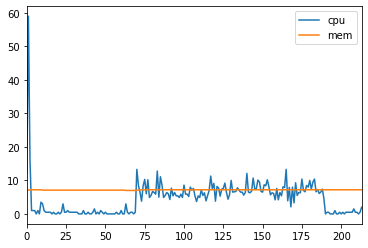

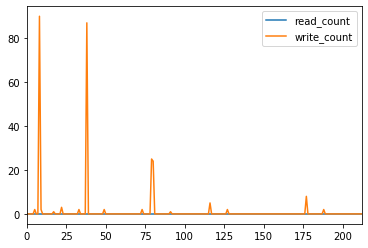

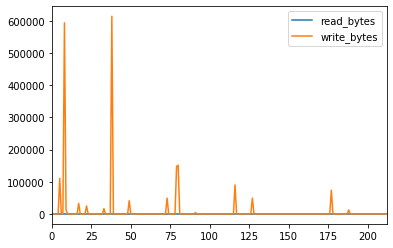

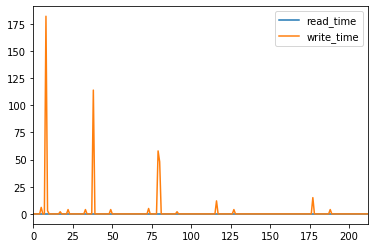

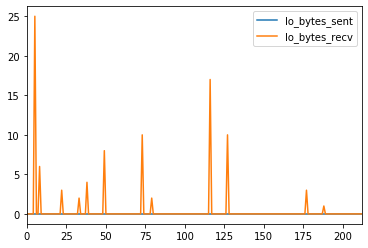

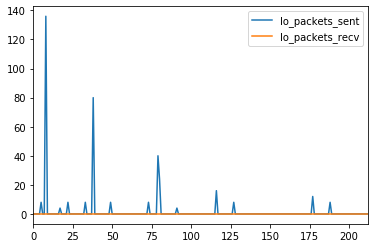

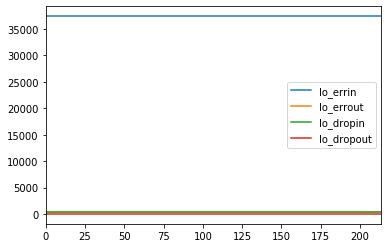

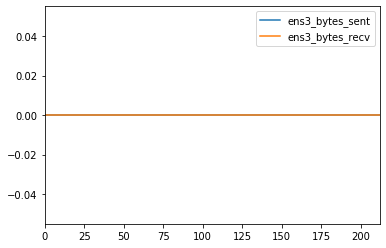

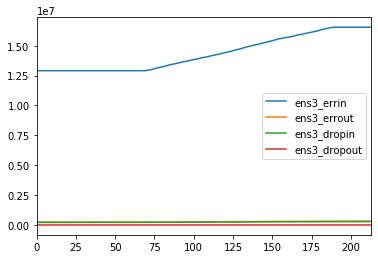

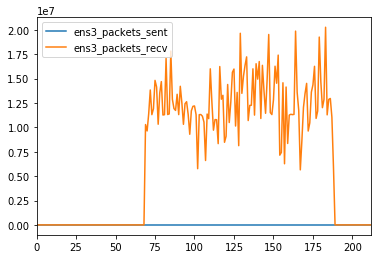

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime


with open('./log_kafka.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()





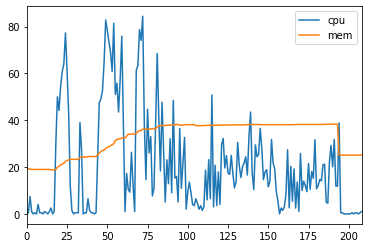

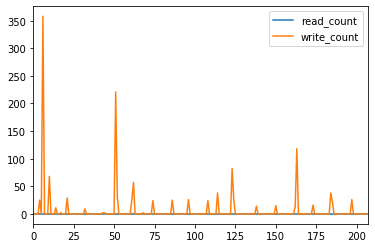

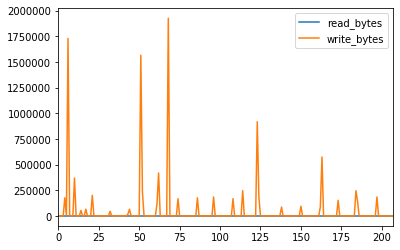

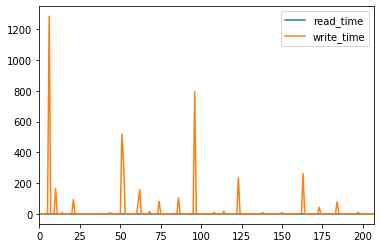

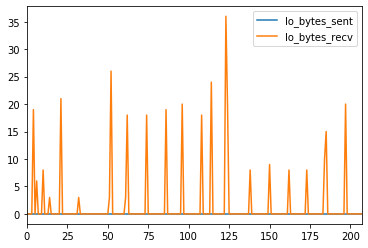

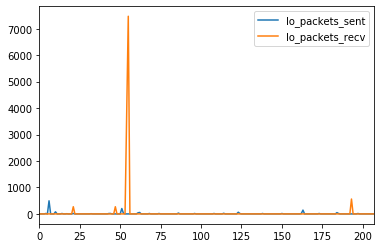

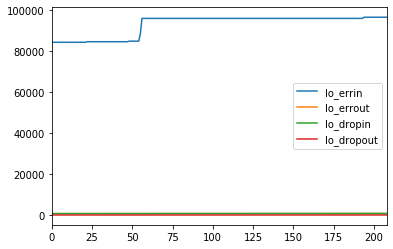

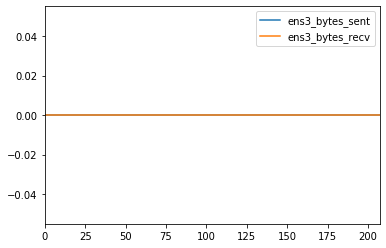

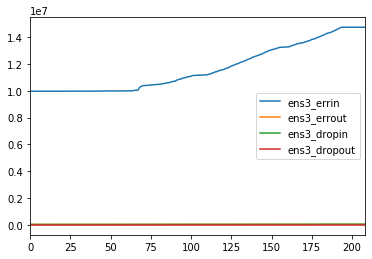

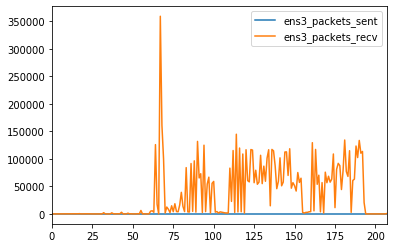

In [31]:
with open('./log_master.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()


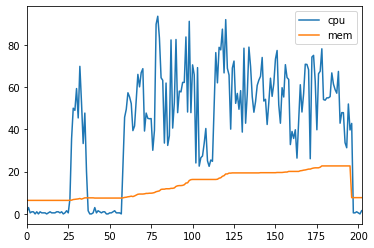

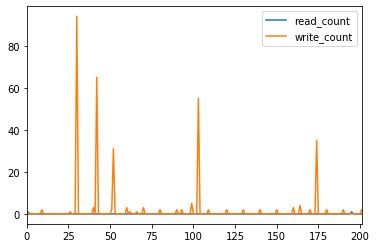

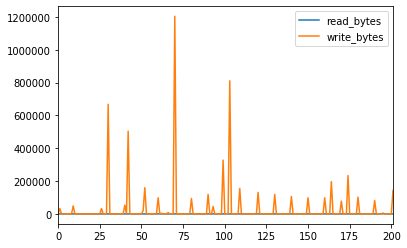

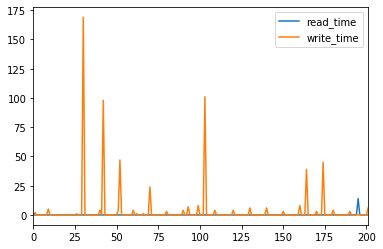

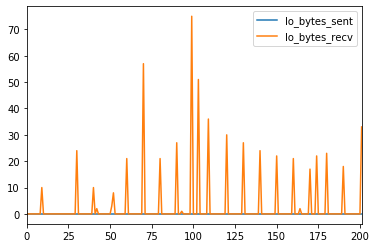

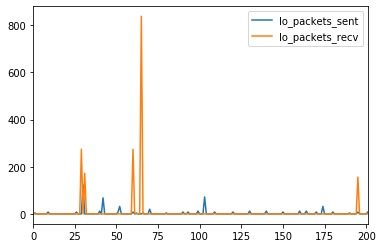

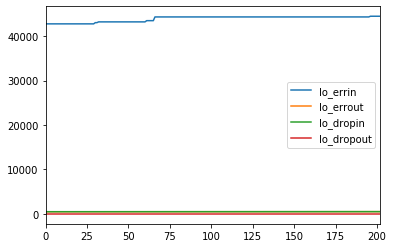

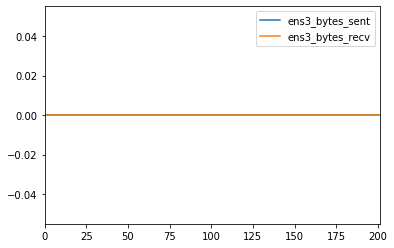

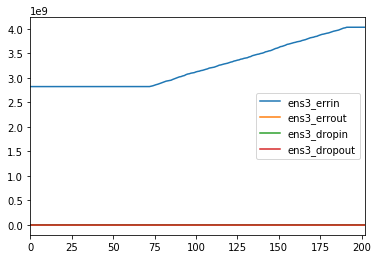

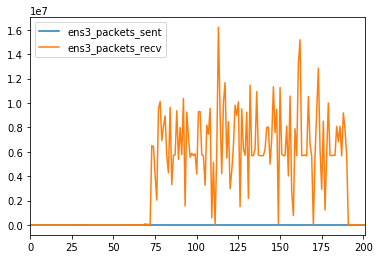

In [32]:
with open('./log_slave1.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()


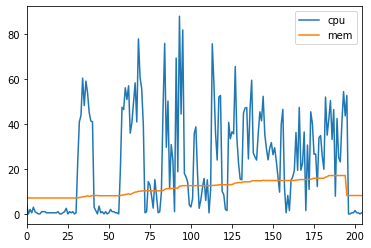

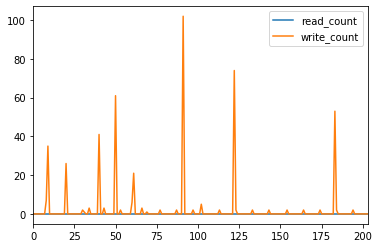

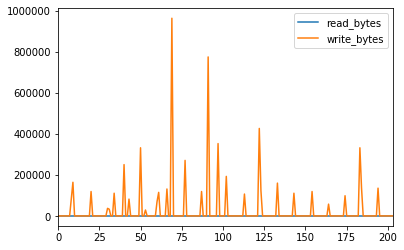

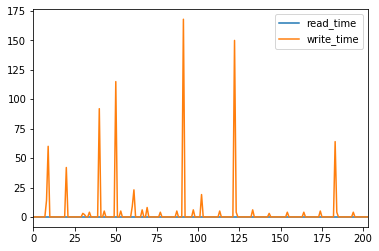

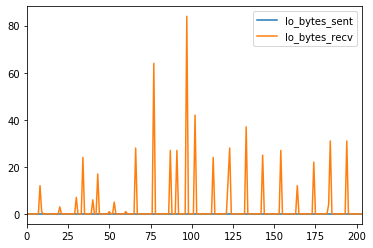

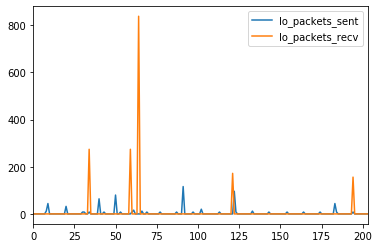

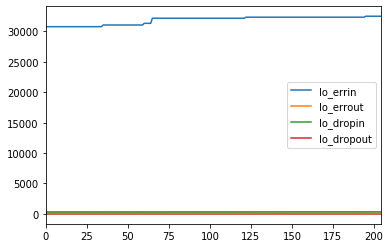

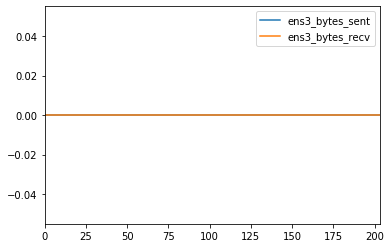

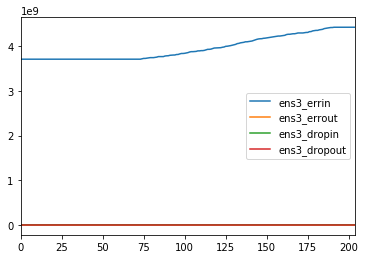

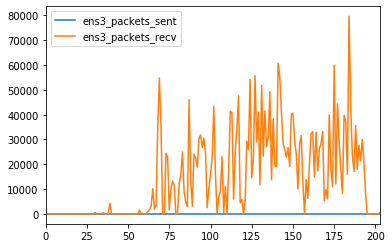

In [33]:
with open('./log_slave2.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()


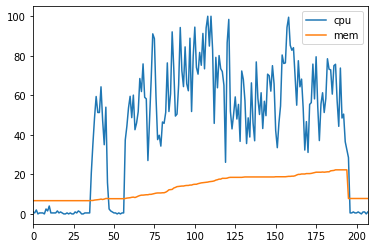

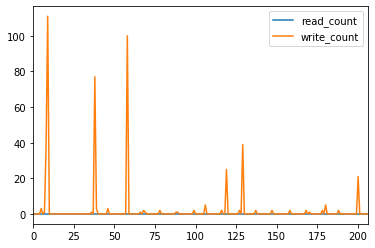

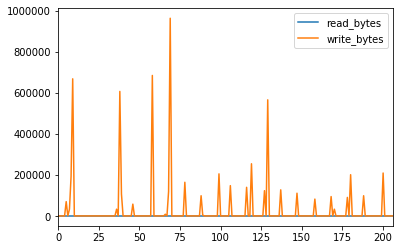

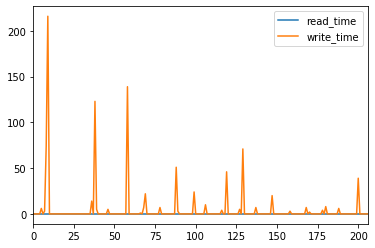

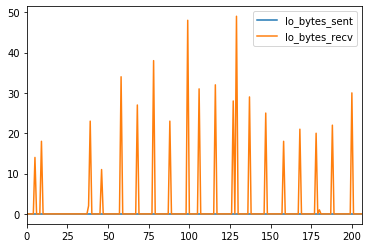

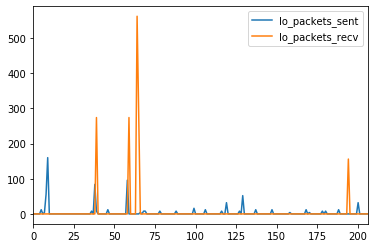

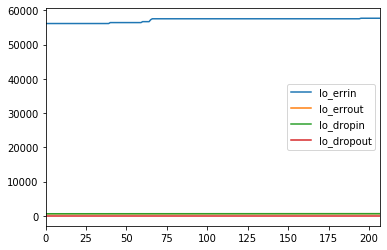

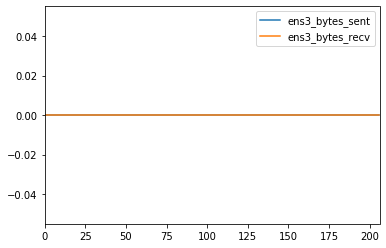

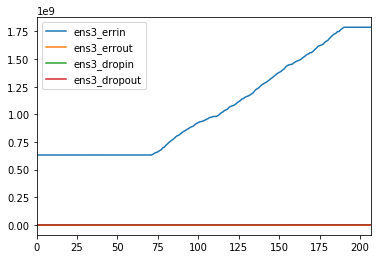

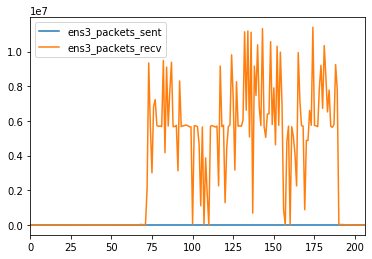

In [35]:
with open('./log_slave3.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()


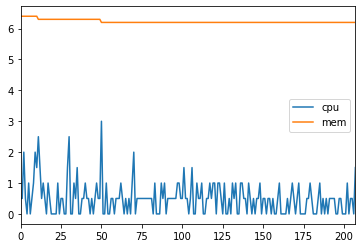

In [6]:
with open('./log_slave4.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()


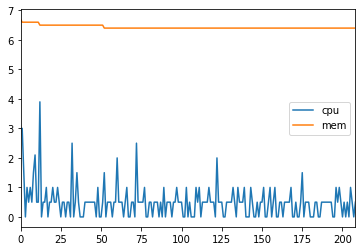

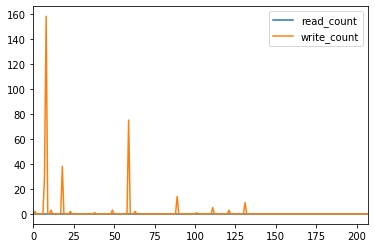

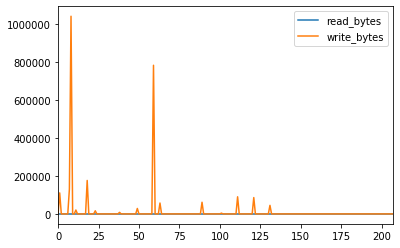

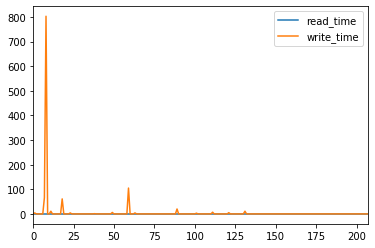

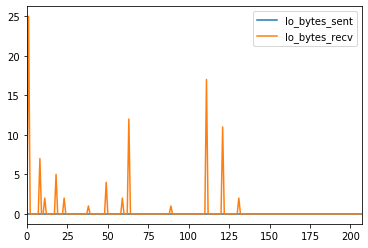

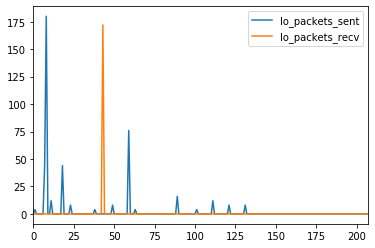

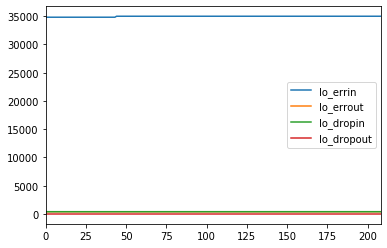

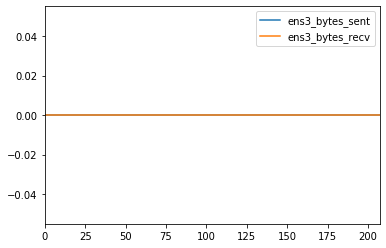

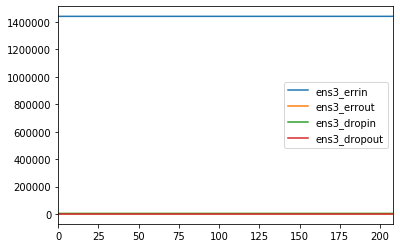

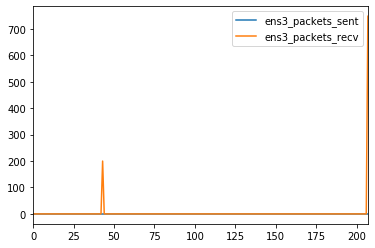

In [34]:
with open('./log_slave5.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()
